# Quality control of data analysis output

When dealing with proteomics data, it is recommended to check the results for inconsistencies and correct application of the data analysis parameters.

### Pre-requisite: mass spectrometry basics

In this workshop, we will focus on mass spectrometry (MS)-based proteomics, which is very frequently used. A mass spectrometer measures the mass-to-charge (m/z) ratio of ionized molecules (e.g., protein fragments/peptides obtained by trypsin digestion of cell extracts and ionized within the spectrometer), and outputs a m/z spectrum encompassing the m/z values of all peptides in a mixture (e.g., a cell extract). 

Then, this spectrum is compared with <b> predictions </b> of the m/z spectrum based on our <i> a priori </i> knowledge of the sample: specie, genomic background, .... etc, using bioinformatics tools, some of which will be used in this session. 
    
Therefore, the typical parameters involved in acquisition/analysis of MS data include: 
1. The retention time (time spent by the solution between the injection in the spectrometer and the measurement)
2. The fragment tolerance: the expected accuracy of the ionization process (i.e., the error on charge measurement)
3. The precursor tolerance: it is the expected accuracy on mass measurements by the analyzer (i.e., the error on mass measurements).
4. Post-translational modifications: PTMs affect the mass-to-charge ratio and might explain unexpected peaks in the MS spectrum. Accounting for PTMs (or not!) in the analysis of a MS spectrum to identify peptides can be critical, and depends on the particular biological purpose of the experiment. 
    
Importantly, by restricting the mass tolerance windows, the number of candidate peptides scored against a MS spectrum are, generally, decreasing.  
    
The purpose of this workshop is to explore how the choice of these analysis parameters affects the output of a MS-based proteomics experiment, using a well controlled dataset. 


### Description of the data

We will use a dataset made of mass spectrometry measurements of samples encompassing a mix of yeast cell extracts (i.e., only yeast peptides), with a library of purified human proteins (termed UPS from now on), the latter being mixed at different concentrations prior to MS-data acquisition ("spike-in" experiment, details provided in https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4706616/).The UPS library consists in 48 human proteins. 

The data has been fully re-analyzed with different parameter settings, where parameters for the fragment ion tolerance, the precursor tolerance or the searched modifications were changed.

For each analysis parameter set, the data has been analysed with two major new tools that generate reports for quality control:

_[PTX-QC](https://cran.r-project.org/web/packages/PTXQC/index.html)_ This is an R package that allows multiple visualizations and metrics for data coming from e.g. MaxQuant or OpenMS workflows. 

_[pmultiqc](https://pypi.org/project/pmultiqc/)_ This Python library is a proteomics plugin for the MultiQC framework that reads output from the [ProteomicsLFQ](https://github.com/nf-core/proteomicslfq) pipeline

Files for protein and peptide quantifications and the quality controls are provided in the folder _QC_Workshop_. Each subfolder corresponds to the data from a different data analysis of the same raw data files. The files _multiqc_report.html_ and _results/ptxqc/report....html_ contain summarized information from the pmultiqc and PTX-QC analysis tools, respectively.

In the following, some Questions will require data generated by the pmultiqc analysis tool, and some other by the PTX-QC tool. 

### Task I: Quality Control

Browse the different reports (html files) and compare the different output between files and across data analyses. 

In order to see the interactive plots, you need to press the button "trust HTML". It might be easier to show the reports in different tabs of your browser (right-click on file and select "Open in New Browser Tab")



#### Add your answers here
(double-click here to edit the cell)

##### Question I:  <ins> How does the Delta Mass distribution (experimental m/z - theoretical m/z) provided by the MultiQC package depend on the different mass tolerances? Explain particular trends you may observe when comparing distributions computed with different tolerances.</ins>

_Answer_

##### Question II:  <ins>Which of the analyses provides the largest number of identified mass spectra/peptides/protein groups, and why? Same question for the lowest number of identified peptides. </ins>

_Answer_

##### Question III:  <ins>What do the graphics representing peptides intensities indicate about the noise in peptide detection, or background signal? Would you pick an intensity threshold for peptide scoring, and if yes which threshold would you take? </ins>

_Answer_

##### Question IV:  <ins>What are miscleavages? How many are found in the data analysis? What does it mean when you find many miscleaved peptides?</ins>

_Answer_

##### Question V:  <ins>What most likely happened with the experiment when there are no identifications over a range of the retention time?</ins>

_Answer_

##### Question VI:  <ins>Look at the number of peptides per protein. There is a considerable amount of one-hit-wonders (only one peptide per protein). Which minimum number for peptides per proteins would you accept? Discuss this in your group, considering different experimental contexts.</ins>

_Answer_



### Task II: Quantitative filtering
We now will check the data by our own and investigate how filtering affects the coverage and interpretation.

For each data analysis, there is a _out_msstats.csv_ file in the respective _results/proteomics_lfq/_ folder.

You can now select one of these files by specifying the folder and test how the output changes when changing the different parameters.

#### Read output file and pre-process data
__The calculation in the following cell can take a little while!__

Click on the cell with the code below and press "shift-enter"

[1] "DONE"


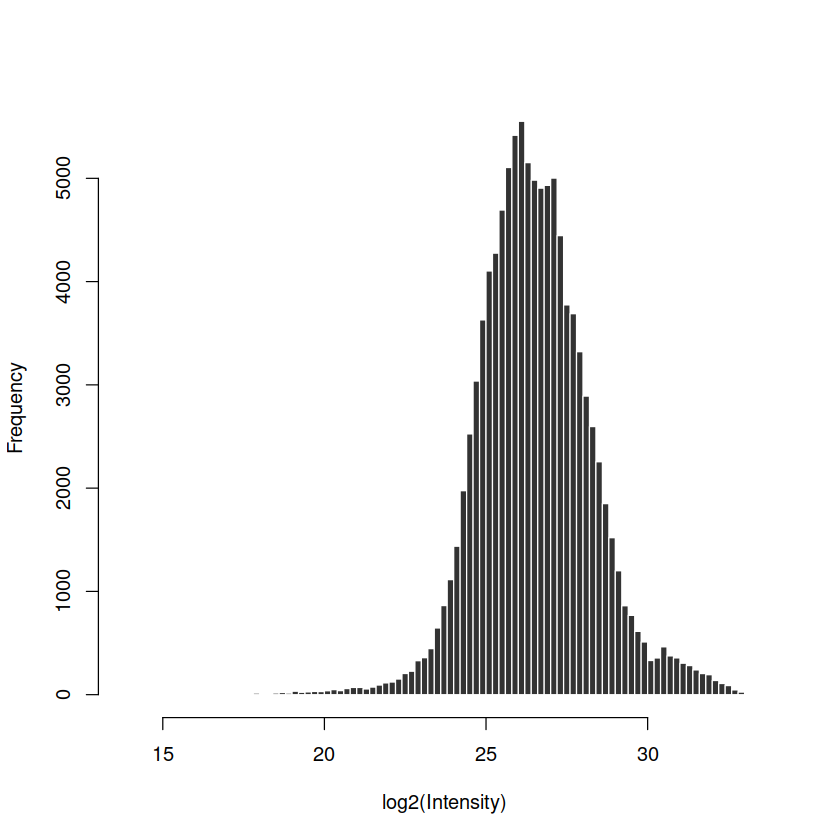

In [4]:
# Change the file path
quant_table <- read.csv("original/results/proteomics_lfq/out_msstats.csv")
# summarize peptides
tpep_table <- by(quant_table, paste0(quant_table$PeptideSequence, quant_table$Run), 
                function(x) c(x[1,c(1,2,7:9,11)], Intensity=sum(x$Intensity,na.rm=T)))
pep_table <- do.call(rbind.data.frame, tpep_table)
                                   
# histogram of intensities
hist(log2(pep_table$Intensity), border=0, col="#333333", xlab="log2(Intensity)", 100, main="")
                                   
print("DONE")
                 



#### Filtering and visualization (identification)

Here you can filter the data differently and check how the filtering affects the results. You can start by increasing the minimal number of peptides min_pep required to identify a protein, and check how the numbers decrease.

Change the code below as described in the comments and run each of the cells with "shift-enter"

In [6]:
## Filter peptide number per protein
# Change this variable
min_pep <- 2
# filter for number of peptides
pep_table$comb <- paste0(pep_table$ProteinName, pep_table$Run)
filtered_peps <- pep_table[pep_table$comb %in% names(which(table(paste0(pep_table$ProteinName, 
                                                                  pep_table$Run)) >= min_pep)),]

## Filter for PTMs
# Use either "none" (none),  "Acetyl" (N-terminal acetylation) or "Oxidation" (Methionine oxidation)
remove_ptm <- "Oxidation"
filtered_peps <- filtered_peps[!grepl(remove_ptm, rownames(filtered_peps)),]

# summary protein groups
tprot_table <- by(filtered_peps, paste0(filtered_peps$ProteinName, filtered_peps$Run), 
                function(x) c(x[1,c(1,3:6)], Intensity = sum(x$Intensity,na.rm=T), Number=length(x$Intensity)))
prot_table <- do.call(rbind.data.frame, tprot_table)





##### Count number of identifications per sample, including al proteins (yeast + UPS)

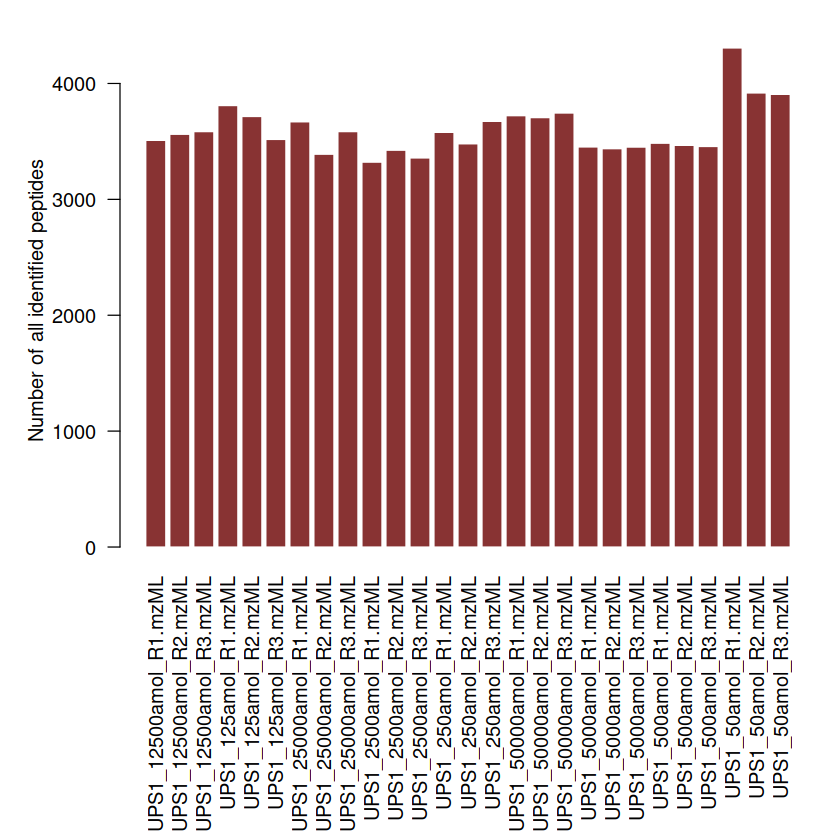

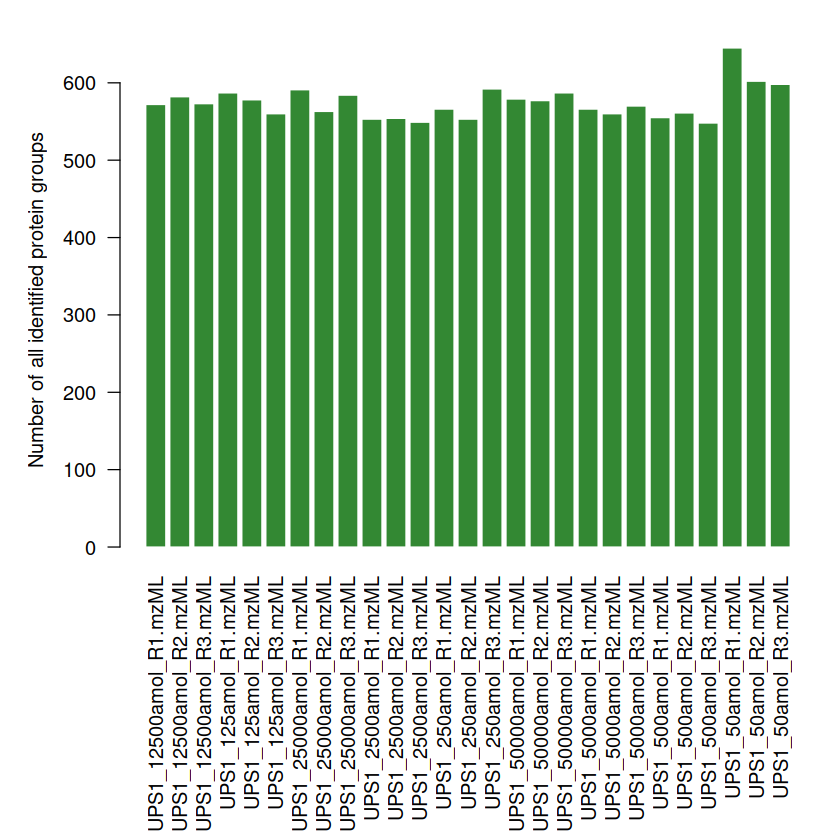

In [7]:
## Plot peptides + proteins per sample
par(mar=c(12,5,2,1))
barplot(unlist(by(filtered_peps, filtered_peps$Reference, nrow)), border=0, col="#883333", 
       las=2, ylab="Number of all identified peptides")                  
barplot(unlist(by(prot_table, prot_table$Reference, nrow)), border=0, col="#338833", 
       las=2, ylab="Number of all identified protein groups")     



#### Add your answers here
(double-click here to edit the cell)

##### Question:  <ins>How much do the numbers decrease when increasing the number of peptides needed to accept a protein or protein group?</ins>

_Answer_

##### Question:  <ins> For which samples (i.e., UPS mix concentration) do we get more peptide/protein identifications? Comment on the sensitivity of the acquisition-analysis pipeline to yeast proteins in presence of an external UPS pool. </ins>

_Answer_



Repeat counting for UPS proteins only. The UPS proteins are spiked in in different concentrations. The sample names contain information about the concentrations.

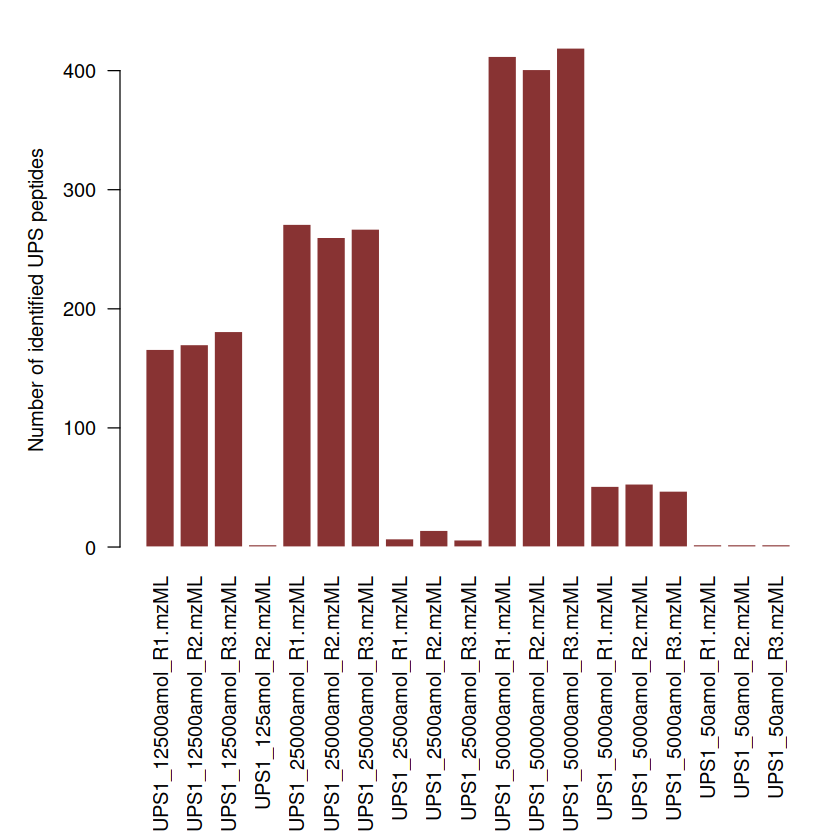

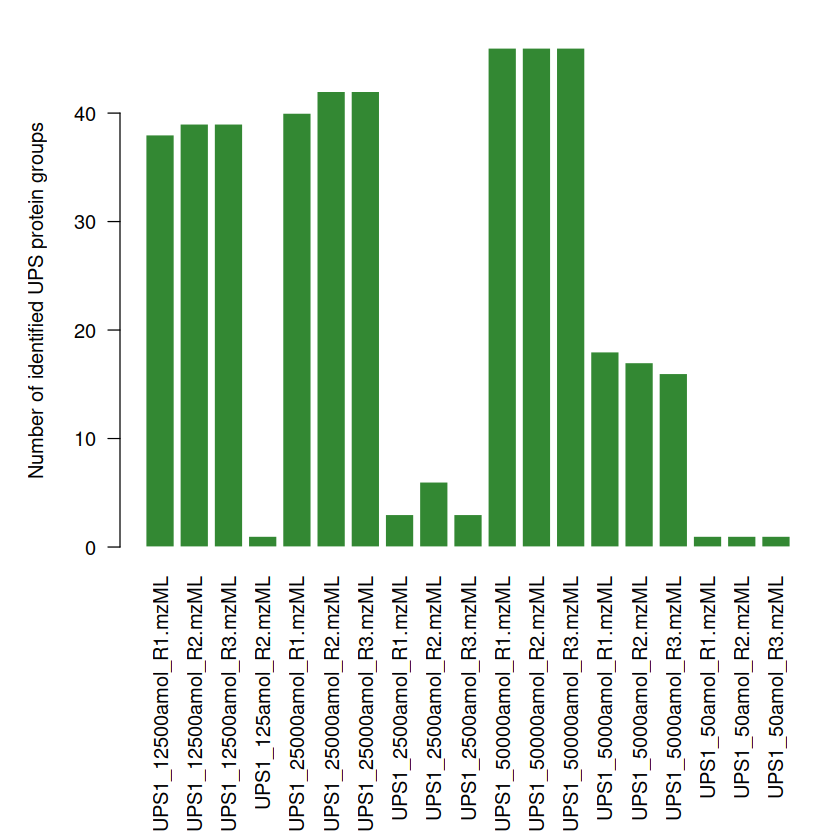

In [8]:
par(mar=c(12,5,2,1))
ups_peptides <- filtered_peps[grepl("UPS", filtered_peps$ProteinName),]                  
ups_proteins <- prot_table[grepl("UPS", prot_table$ProteinName),]                  
barplot(unlist(by(ups_peptides, ups_peptides$Reference, nrow)), 
       border=0, col="#883333", 
       las=2, ylab="Number of identified UPS peptides")                  
barplot(unlist(by(ups_proteins, ups_proteins$Reference, nrow)), 
        border=0, col="#338833", las=2, ylab="Number of identified UPS protein groups")                  
par(mar=c(5.1,4.1,4.1,2))                  


#### Add your answers here
(double-click here to edit the cell)

##### Question:  <ins>How does the detection of UPS proteins depend on the mix concentration? How would you define the detection limit (in amol)? </ins>

_Answer_

##### Question:  <ins>How accurate would it be to use spectral counting for the quantification of all UPS proteins together?</ins>

_Answer_



#### Visualization (Quantification)

This cell creates matrices containing the quantifications from all samples. Proteins are quantified by taking the sum of the peptide intensities.

In [9]:
## you might need to install these libraries via "install.packages(c("gplots", "lattice", "matrixStats"))"
library(gplots)
library(lattice)
library(matrixStats)

# Populated matrices with columns as samples
quant_peps <- matrix(NA, dimnames=list(rows=unique(filtered_peps$PeptideSequence), 
                                   cols=unique(filtered_peps$Reference)), 
                    nrow=length(unique(filtered_peps$PeptideSequence)), 
                     ncol=length(unique(filtered_peps$Reference)))
for(i in colnames(quant_peps)) {
    tquant <- filtered_peps[filtered_peps$Reference == i, ]
    quant_peps[tquant$PeptideSequence, i] <- log2(tquant$Intensity)
}

quant_prots <- matrix(NA, dimnames=list(rows=unique(prot_table$ProteinName), 
                                   cols=unique(prot_table$Reference)), 
                    nrow=length(unique(prot_table$ProteinName)), 
                     ncol=length(unique(prot_table$Reference)))
for(i in colnames(quant_prots)) {
    tquant <- prot_table[prot_table$Reference == i, ]
    quant_prots[tquant$ProteinName, i] <- log2(tquant$Intensity)
}




Attaching package: ‘gplots’


The following object is masked from ‘package:stats’:

    lowess




##### Calculate the correlations between peptide abundances

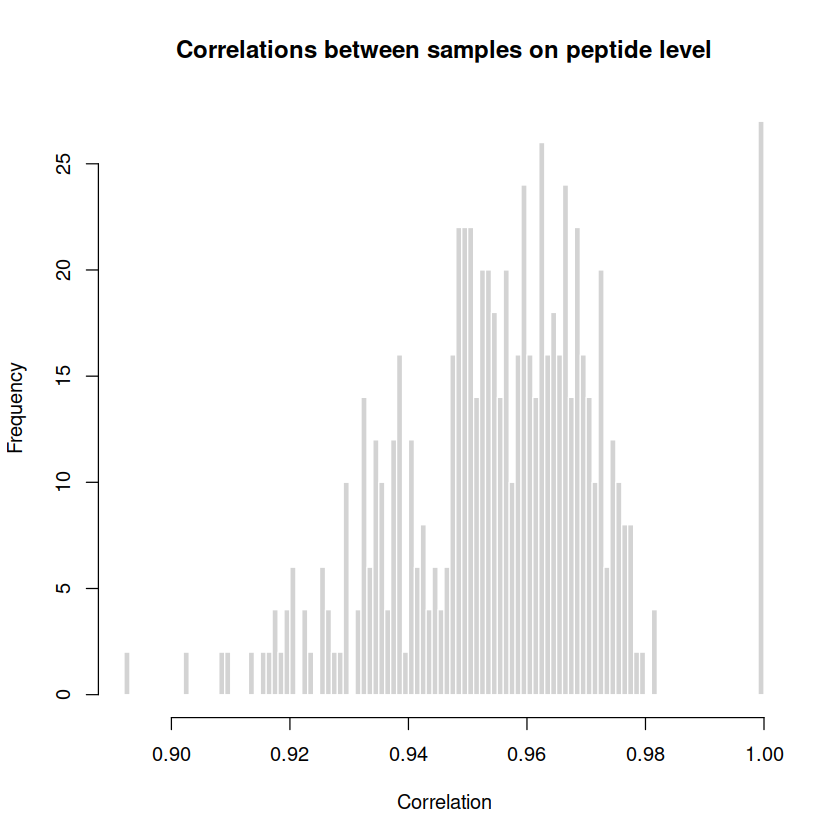

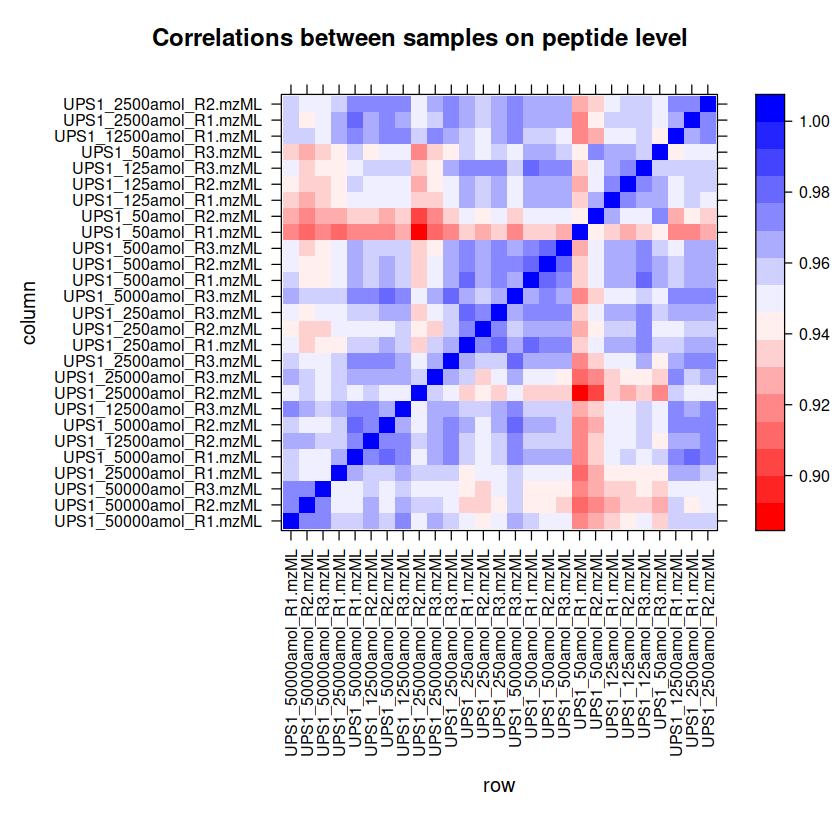

In [10]:
## Correlations on peptide level (how reproducibly are yeast peptides quantified?)
cors <- cor(quant_peps, use="na.or.complete")
hist(cors, main="Correlations between samples on peptide level", 
     100, border=0, xlab="Correlation")
levelplot(cors, col.regions=colorpanel(100, "red","white","blue"), scales=list(x=list(rot=90)),
         main="Correlations between samples on peptide level")





#### Add your answers here
(double-click here to edit the cell)

##### Question:  <ins>Why do you see such a high similarity between all samples? Are there only biological reasons for that?</ins>

_Answer_

##### Question:  <ins>Which factors contribute to the individual peptide intensities?</ins>

_Answer_



##### Determine quantitative changes of UPS proteins

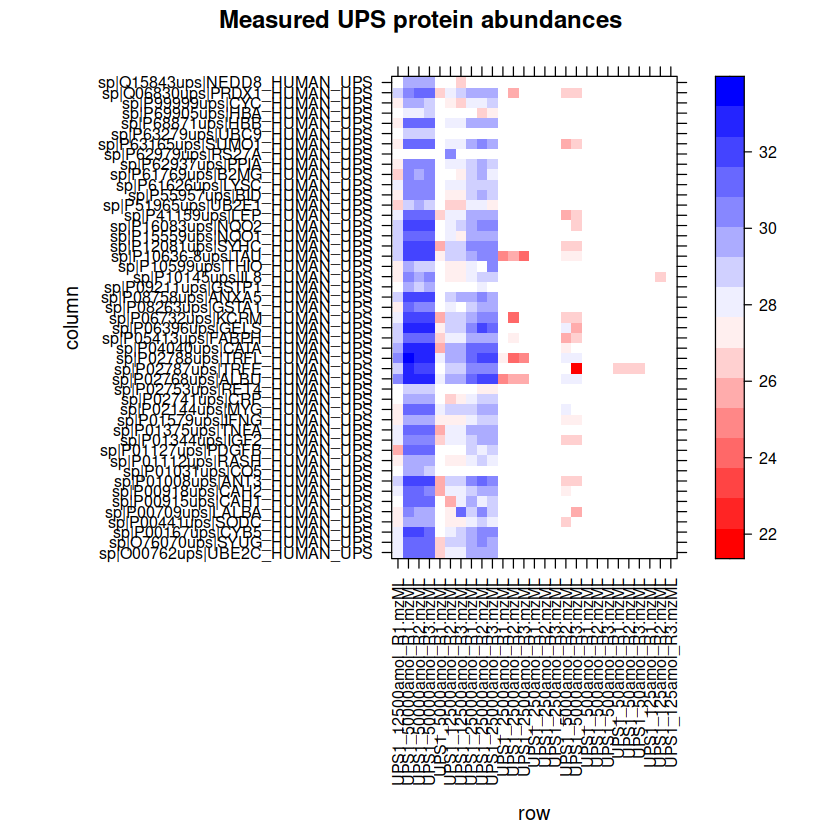

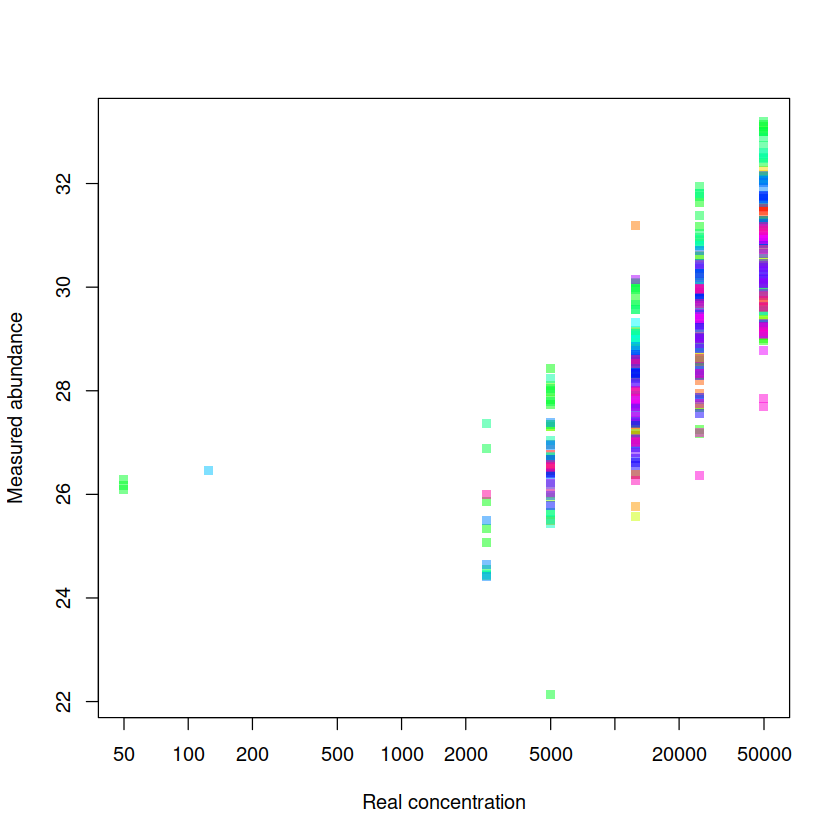

In [18]:
# now only UPS proteins as they change between samples
ups_quant_proteins <- quant_prots[grep("UPS", rownames(quant_prots)),]

levelplot(t(ups_quant_proteins), col.regions=colorpanel(100, "red","white","blue"), scales=list(x=list(rot=90)),
         main="Measured UPS protein abundances")

# comparing to real concentrations
concentrations <- sub("[a-z].*","",unlist(strsplit(colnames(ups_quant_proteins), "_"))
                      [seq(2, ncol(ups_quant_proteins)*3, 3)])
colors <- rainbow(50 ,alpha = 0.5)
plot(concentrations, ups_quant_proteins[1,], type="p", xlab="Real concentration", ylab="Measured abundance",
    log="x", ylim=range(ups_quant_proteins, na.rm=T), pch=15, col=colors[1])
for(i in 2:nrow(ups_quant_proteins)) 
    points(concentrations, ups_quant_proteins[i, ], pch=15, col=colors[i])


#### Add your answers here
(double-click here to edit the cell)

##### Question:  <ins>What would be your preferred setting for the filtering and why?</ins>

_Answer_

##### Question:  <ins>Why do the different UPS proteins have different abundances despite of having been loaded in equal amounts?</ins>

_Answer_

